In [90]:
import dlib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import dlib
import imutils
import os
import csv

# Path to images
image_path = "images/img/Hillary.jpg"
crop_image = "images/img/crop.jpg"

Detect and Crop Faces

In [91]:
import cv2
import sys
import os

class FaceCropper(object):
    CASCADE_PATH = "data/haarcascade_frontalface_default.xml"

    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier(self.CASCADE_PATH)

    def generate(self, image_path, show_result):
        img = cv2.imread(image_path)
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = self.face_cascade.detectMultiScale(gray, 1.2, 4)
        if (show_result):
            for (x, y, w, h) in faces:
                cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
            cv2.imshow('img', img)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

        facecnt = len(faces)
        print("Detected faces: %d" % facecnt)
        i = 0
        height, width = img.shape[:2]

        for (x, y, w, h) in faces:
            r = max(w, h) / 2
            centerx = x + w / 2
            centery = y + h / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)

            faceimg = img[ny:ny+nr, nx:nx+nr]
            lastimg = cv2.resize(faceimg, (200, 200))
            i += 1
            cv2.imwrite(crop_image, lastimg)


detecter = FaceCropper()
detecter.generate(image_path, True)

Detected faces: 1


Detect 68 landmarks

In [92]:
def shape_to_numpy_array(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    all_face = np.zeros((68, 2), dtype=dtype)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        all_face[i] = (shape.part(i).x, shape.part(i).y)

    return all_face

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("data/shape_predictor_68_face_landmarks.dat")

image = cv2.imread(crop_image)
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# detect faceas in the grayscale image
rects = detector(gray, 1)

# loop over the face detections
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the face region, then
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    all_face = shape_to_numpy_array(shape)

In [ ]:
for (x, y) in all_face:
    cv2.circle(image, (x, y), 4, (0, 0, 255), -1)
cv2.imshow("Output", image)
cv2.waitKey(0)

Load Model and Do Classification

In [94]:
import torch
import torchvision
import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self,k):
        super(CNN, self).__init__()

        # define the layers
        # kernel size = 3 means (3,3) kernel
        # rgb -> 3 -> in channel
        # number of feature maps = 16
        # number of filters = 3 x 16
        self.l1 = nn.Conv2d(kernel_size=3, in_channels=3, out_channels=16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # MaxPool2d, AvgPool2d.
        # The first 2 = 2x2 kernel size,
        # The second 2 means the stride=2

        self.l2 = nn.Conv2d(kernel_size=3, in_channels=16, out_channels=32)

        # FC layer
        self.fc1 = nn.Linear(32 * 48 * 48, k) # NUM OF CLUSTER
    
    def forward(self, x):
        # define the data flow through the deep learning layers
        x = self.pool(F.relu(self.l1(x))) # 16x16 x 14 x 14
        #print(x.shape)
        x = self.pool(F.relu(self.l2(x))) # 16x32x6x6
        #print(x.shape)
        x = x.reshape(-1, 32*48*48) # [16 x 1152]# CRUCIAL:
        #print(x.shape)
        x = self.fc1(x)
        return x

eye_model = CNN(3)
eye_model.load_state_dict(torch.load("models/eye_model.pt"))
# eye_model.eval()
eyebrow_model = CNN(3)
eyebrow_model.load_state_dict(torch.load("models/eyebrow_model.pt"))
jaw_model = CNN(4)
jaw_model.load_state_dict(torch.load("models/jaw_model.pt"))
mouth_model = CNN(3)
mouth_model.load_state_dict(torch.load("models/mouth_model.pt"))
nose_model = CNN(3)
nose_model.load_state_dict(torch.load("models/nose_model.pt"))

preprocess = torchvision.transforms.Compose([
     # torchvision.transforms.RandomAffine(10),
     torchvision.transforms.ToTensor()
])

img = Image.open(crop_image)
img_tensor = preprocess(img)
img_tensor.unsqueeze_(0)
eyebrow = eyebrow_model(Variable(img_tensor))
eye = eye_model(Variable(img_tensor))
nose = nose_model(Variable(img_tensor))
mouth = mouth_model(Variable(img_tensor))
jaw = jaw_model(Variable(img_tensor))

Dictionary

In [95]:
types = dict()
types["eyebrow"] = ["Arch","Circle","Straight"]
types["eye"] = ["Big","Silt","Small"]
types["nose"] = ["Long","Small","Wide"]
types["mouth"] = ["Medium","Small","Thick"]
types["jaw"] = ["Circle","Oval","Square","Triangle"]

import json
def print_description(region_name,region_type):
    with open('data/analysis.json') as json_file:
        data = json.load(json_file)
        for region in data["face_regions"]:
            if region["name"] == region_name:
                for feature in region["features"]:
                    if feature["name"] == region_type:
                        print(feature["analysis"])

Visualize All the Results

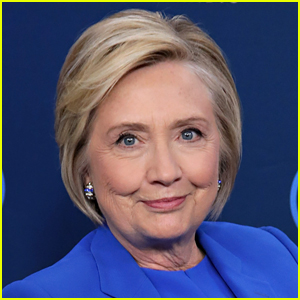

In [96]:
from IPython.display import Image
Image(image_path)

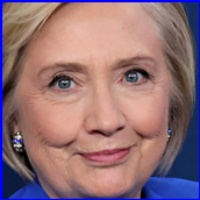

In [97]:
Image(crop_image)

In [98]:
print("\n")
eyebrow_shape = types["eyebrow"][torch.argmax(eyebrow).item()]
print("Eyebrow:  ",eyebrow_shape)
print_description("eyebrows",eyebrow_shape)
print("\n")

eye_shape = types["eye"][torch.argmax(eye).item()]
print("Eye:      ",eye_shape)
print_description("eyes",eye_shape)
print("\n")

nose_shape = types["nose"][torch.argmax(nose).item()]
print("Nose:     ",nose_shape)
print_description("nose",nose_shape)
print("\n")

mouth_shape = types["mouth"][torch.argmax(mouth).item()]
print("Mouth:    ",mouth_shape)
print_description("mouth",mouth_shape)
print("\n")

jaw_shape = types["jaw"][torch.argmax(jaw).item()]
print("Jaw:      ",jaw_shape)
print_description("face",jaw_shape)
print("\n")



Eyebrow:   Straight
Usually with great perseverance and courage. People with thick straight eyebrows are often strong-willed, courageous and stern. People with thin straight eyebrows are often clever, talented and shrewd.


Eye:       Big
Kind and compassionate, can be good friends to talk with. Good understanding of movie and arts, sometime overwhelmed by emotions.


Nose:      Small
People with small noses are thoughtful and sensitive, have a conservative and peaceful personality, hesitate to act, have less ambition, and are relatively flat in middle age. Men must work harder at work, and women are slightly delayed in marriage some.


Mouth:     Thick
Passionate and warm-hearted, emphasizing sensory stimuli, doing things practically and resentful, and less likely to use tricks.


Jaw:       Oval
More likely to have better improvement in their careers. They also spend more money and pay attention to quality of life.


